# Init

In [1]:
import glob
from PIL import Image, ImageEnhance, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
from sklearn import preprocessing
import itertools
import random

import torch.nn.functional as F
from torchmetrics.functional import accuracy

import torchmetrics
from torchvision.transforms import ToTensor, RandomErasing, Compose, ToPILImage
from torch import nn, Tensor
from torch.utils.data import Dataset ,DataLoader
from sklearn.model_selection import train_test_split as tts
from torchvision import transforms
from torchvision.models import resnet18
from typing import List 
import pytorch_lightning as pl
import pandas as pd
from sklearn.manifold import TSNE
import seaborn as sns

/home/ubuntu/workspace/venv/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/workspace/venv/lib/python3.8/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


# Cutpaste

## Approccio iniziale

CutPaste

Tagliare una patch e incollarla casualmente sulla stessa immagine

L'idea è di generare anomalie fittizie per addestrare il modello di pretext task e generare le rappresentazioni da trasferire nel task di downstream (anomaly detection)

Data augmentation per pretext task

Per ogni immagine del dataset, generare 4 immagini con 4 rotazioni differenti [0°, 90°, 180°, 270°]

per ogni immagine ruotata, sono generate 3 immagini. Per ogni immagine sono applicate modifiche casuali sul colore, e inoltre sono fatte le seguenti trasformazioni:
*   No trasformazione (good - 0)
*   CutPaste (cutpaste - 1)
*   Scar (scar - 2)


In [2]:
imsize=(256,256)
good0 = Image.open("/home/ubuntu/workspace/dataset/bottle/train/good/000.png").resize(imsize)
good1 = Image.open("/home/ubuntu/workspace/dataset/bottle/train/good/001.png").resize(imsize)
good2 = Image.open("/home/ubuntu/workspace/dataset/bottle/train/good/002.png").resize(imsize)
good3 = Image.open("/home/ubuntu/workspace/dataset/bottle/train/good/003.png").resize(imsize)
good4 = Image.open("/home/ubuntu/workspace/dataset/bottle/train/good/004.png").resize(imsize)

good_bottles = [good0, good1, good2, good3, good4]

### Rotations

In [3]:
def generate_rotations(image):
  r90 = image.rotate(90)
  r180 = image.rotate(180)
  r270 = image.rotate(270)
  return image, r90, r180, r270

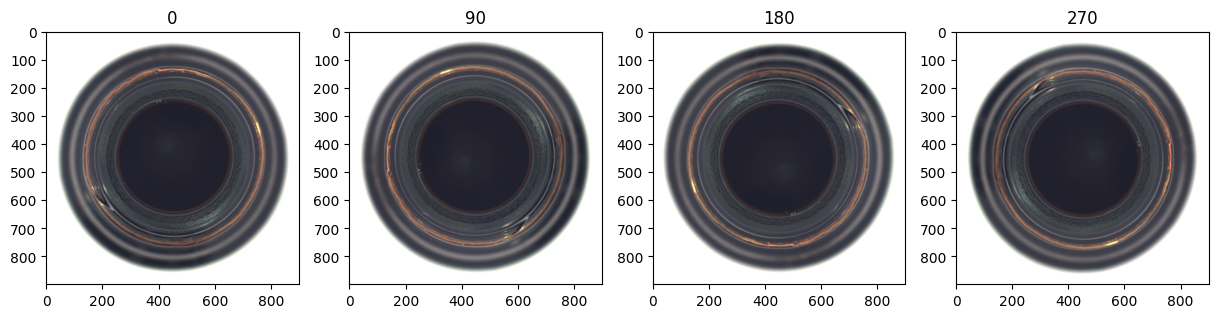

In [4]:
image = Image.open("/home/ubuntu/workspace/dataset/bottle/train/good/002.png")
fig, axs = plt.subplots(1, 4, figsize=(15,15))
r0, r90, r180, r270 = generate_rotations(image)
rotations = [r0, r90, r180, r270]
c = 0
for i in range(len(rotations)):
  axs[i].set_title(str(c))
  axs[i].imshow(rotations[i])
  c+=90

### Cut

taglio delle patches effettuato prendendo in considerazione rateo dell'area  della patch rispetto all'immagine totale, andando a considerare anche aspect ratio per favorire figure rettangolari
* area ratio = (0.02, 0.15)
* aspect ratio = (0.3, 1) U (1, 3.3)

In [5]:
import math
def generate_patch(image:Image, 
                    area_ratio=(0.02, 0.15), 
                    aspect_ratio=((0.3, 1),(1, 3.3))):
  img_area = image.size[0] * image.size[1]
  patch_area = random.uniform(*area_ratio) * img_area
  patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
  patch_w  = int(np.sqrt(patch_area*patch_aspect))
  patch_h = int(np.sqrt(patch_area/patch_aspect))
  org_w, org_h = image.size

  patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
  paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  
  return image.crop((patch_left, patch_top, patch_right, patch_bottom)), (paste_left, paste_top)

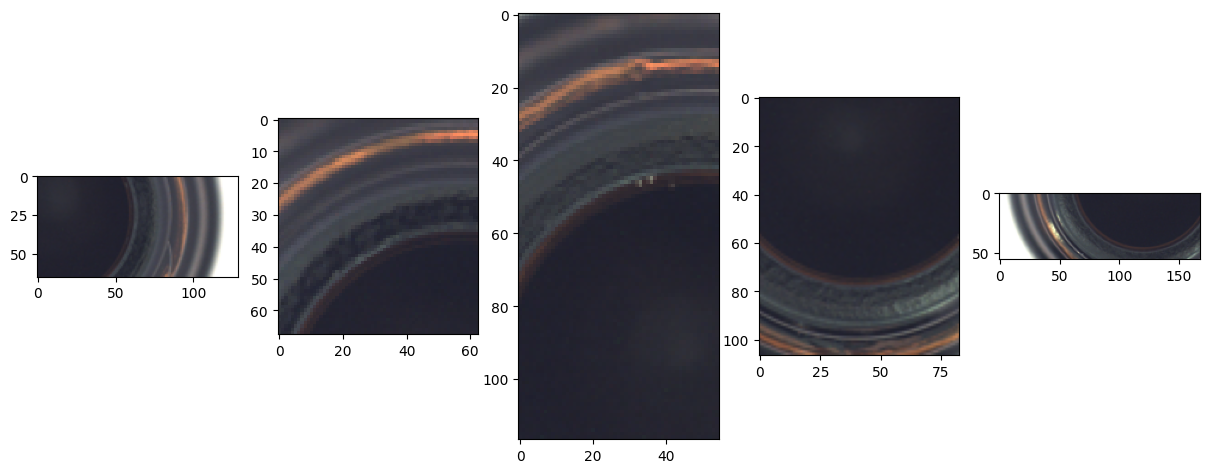

In [6]:
random.seed(0)
fig, axs = plt.subplots(1, 5, figsize=(15,15))
for i in range(len(good_bottles)):
  patch, _ = generate_patch(good_bottles[i])
  axs[i].imshow(patch)

### Patch transformations

Applicare data augmentation sulle patch
* contrasto
* nitidezza
* saturazione
* luminosità
* tonalità

L'idea è rendere uniche le patch tra di loro e favorire maggior generalizzazione

In [7]:
def apply_patch_augmentations(patch:Image, 
                              augmentations:transforms.ColorJitter=None):
  return augmentations(patch)

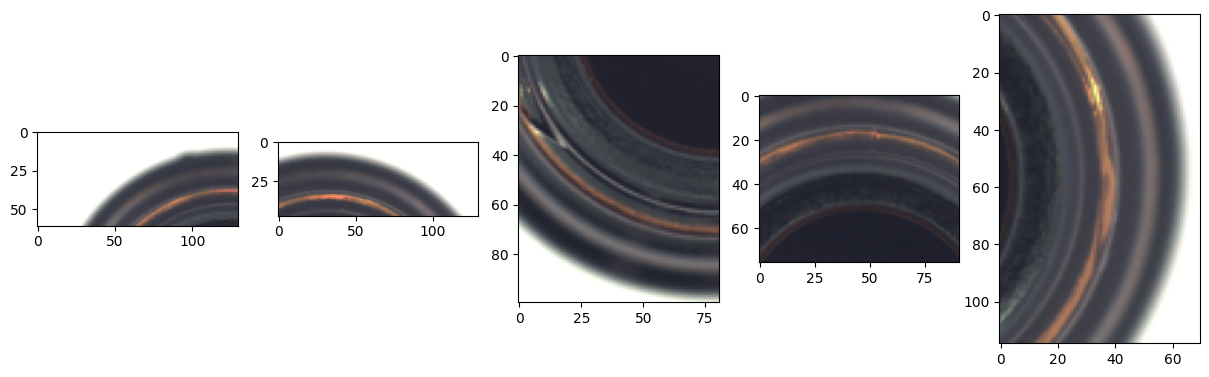

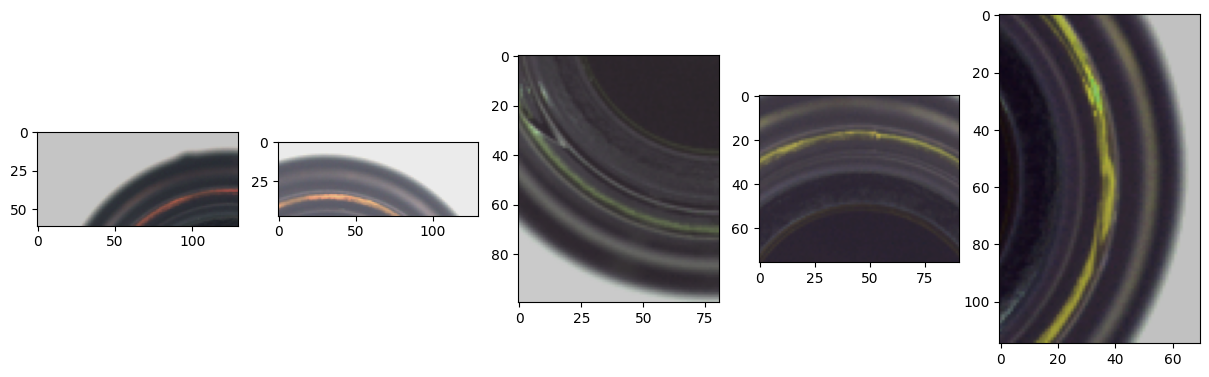

In [8]:
augs = transforms.ColorJitter(brightness = 0.3,
                              contrast = 0.3,
                              saturation = 0.3,
                              hue = 0.3)

def show_patches():
  random.seed(6)
  fig, axs = plt.subplots(1, 5, figsize=(15,15))
  patches = []
  for i in range(len(good_bottles)):
    patch, _ = generate_patch(good_bottles[i])
    patches.append(patch)
    axs[i].imshow(patch)
  fig, axs = plt.subplots(1, 5, figsize=(15,15))
  for i in range(len(good_bottles)):
    aug_patch = apply_patch_augmentations(patches[i], augs)
    axs[i].imshow(aug_patch)

show_patches()

### Paste

In [9]:
def paste_patch(image, patch, coords, mask = None):
  aug_image = image.copy()
  aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
  return aug_image

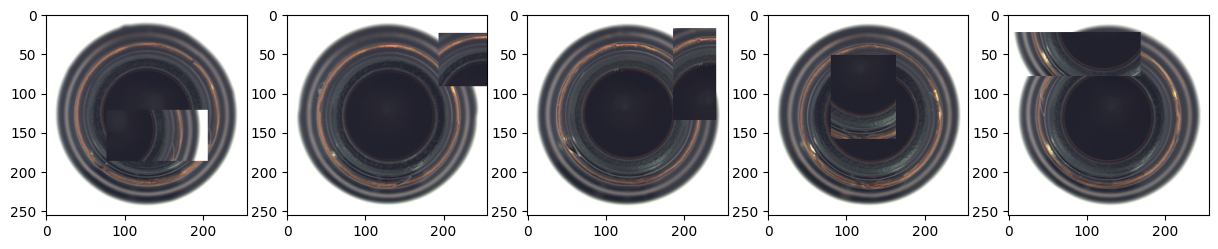

In [10]:
random.seed(0)
fig, axs = plt.subplots(1, 5, figsize=(15,15))
for i in range(len(good_bottles)):
  patch, coords = generate_patch(good_bottles[i])
  aug_im = paste_patch(good_bottles[i], patch, coords)
  axs[i].imshow(aug_im)

(esempio senza le trasformazioni, solo cutpaste)

### Scars

In [11]:
def random_color():
  return random.randint(10,240)

def generate_scar(imsize:tuple, w_range=(2,16), h_range=(10,25)):
  img_w, img_h = imsize

  #dimensioni sezione
  scar_w = random.randint(w_range[0], w_range[1])
  scar_h = random.randint(h_range[0], h_range[1])

  r = random_color()
  g = random_color()
  b = random_color()

  color = (r,g,b)

  scar = Image.new('RGBA', (scar_w, scar_h), color=color)
  angle = random.randint(-45, 45)
  scar = scar.rotate(angle, expand=True)

  #posizione casuale della sezione
  left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  return scar, (left, top)

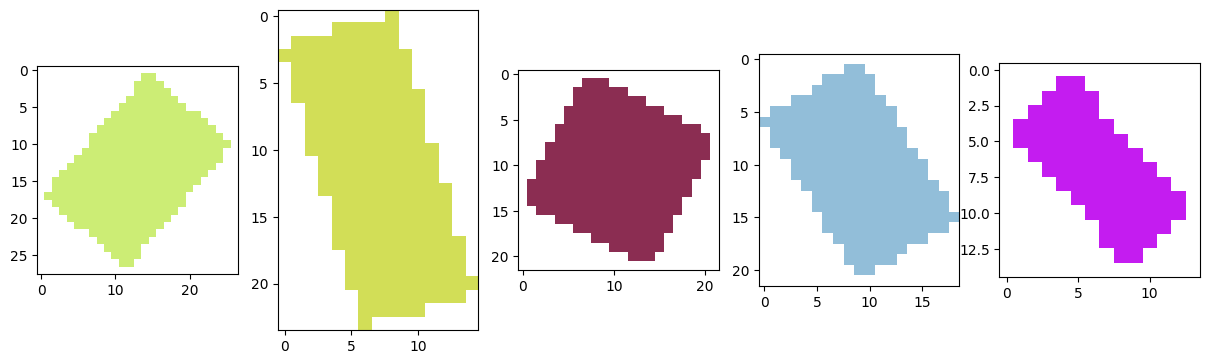

In [12]:
random.seed(0)
fig, axs = plt.subplots(1, 5, figsize=(15,15))
for i in range(len(good_bottles)):
  scar, coords = generate_scar((256,256))
  axs[i].imshow(scar)

### Examples

In [13]:
def show_examples(gb_examples, figsize=(16,16)):
  random.seed(0)
  augs = transforms.ColorJitter(brightness = 0.3,
                                contrast = 0.3,
                                saturation = 0.3,
                                hue = 0.3)

  fig, axs = plt.subplots(1, 8, figsize=figsize)
  for i in range(len(gb_examples)):
    axs[i].axis('off')
    axs[i].imshow(gb_examples[i])

  fig, axs = plt.subplots(1, 8, figsize=figsize)
  for i in range(len(gb_examples)):
    patch, coords = generate_patch(gb_examples[i])
    patch = apply_patch_augmentations(patch, augs)
    aug_im = paste_patch(gb_examples[i], patch, coords)
    axs[i].axis('off')
    axs[i].imshow(aug_im)

  fig, axs = plt.subplots(1, 8, figsize=figsize)
  for i in range(len(gb_examples)):
    scar, coords = generate_scar(gb_examples[i].size)
    scar_im = paste_patch(gb_examples[i], scar, coords, scar)
    axs[i].axis('off')
    axs[i].imshow(scar_im)

Esempi di cutpaste

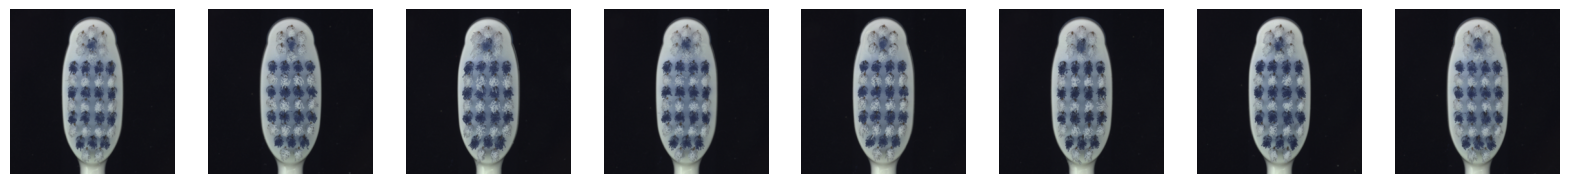

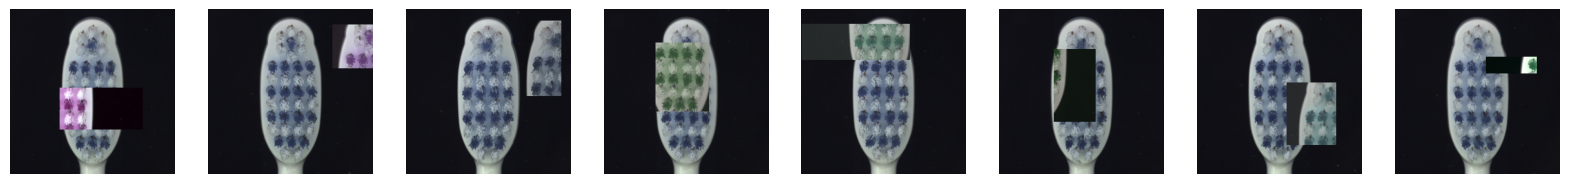

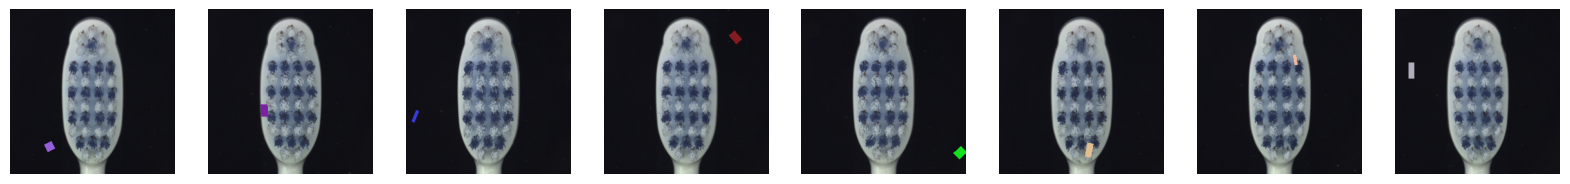

In [ ]:
subject = 'toothbrush'

imsize=(256,256)
good0 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/000.png").resize(imsize)
good1 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/001.png").resize(imsize)
good2 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/002.png").resize(imsize)
good3 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/003.png").resize(imsize)
good4 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/004.png").resize(imsize)
good5 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/005.png").resize(imsize)
good6 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/006.png").resize(imsize)
good7 = Image.open("/home/ubuntu/workspace/dataset/"+subject+"/train/good/007.png").resize(imsize)

good_examples = [good0, good1, good2, good3, good4, good5, good6, good7]
show_examples(good_examples, figsize=(20,20))

## Pretext Task

Addestrare un modello per generare le rappresentazioni (attention maps) rispetto alle immagini anomale e normali

Modello: Res-Net18

### Funzioni

In [ ]:
import math

def generate_rotations(image:Image):
  r90 = image.rotate(90)
  r180 = image.rotate(180)
  r270 = image.rotate(270)
  return image, r90, r180, r270


def generate_patch(image:Image, 
                    area_ratio=(0.02, 0.15), 
                    aspect_ratio=((0.3, 1),(1, 3.3))):
  img_area = image.size[0] * image.size[1]
  patch_area = random.uniform(*area_ratio) * img_area
  patch_aspect = random.choice([random.uniform(*aspect_ratio[0]), random.uniform(*aspect_ratio[1])])
  patch_w  = int(np.sqrt(patch_area*patch_aspect))
  patch_h = int(np.sqrt(patch_area/patch_aspect))
  org_w, org_h = image.size

  patch_left, patch_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  patch_right, patch_bottom = patch_left + patch_w, patch_top + patch_h
  paste_left, paste_top = random.randint(0, org_w - patch_w), random.randint(0, org_h - patch_h)
  
  return image.crop((patch_left, patch_top, patch_right, patch_bottom)), (paste_left, paste_top)


def paste_patch(image, patch, coords, mask = None):
  aug_image = image.copy()
  aug_image.paste(patch, (coords[0], coords[1]), mask=mask)
  return aug_image


def apply_patch_augmentations(patch:Image, 
                              augmentations:transforms.ColorJitter=None):
  return augmentations(patch)


def random_color():
  return random.randint(10,240)

def generate_scar(imsize:tuple, w_range=(2,16), h_range=(10,25)):
  img_w, img_h = imsize

  #dimensioni sezione
  scar_w = random.randint(w_range[0], w_range[1])
  scar_h = random.randint(h_range[0], h_range[1])

  r = random_color()
  g = random_color()
  b = random_color()

  color = (r,g,b)

  scar = Image.new('RGBA', (scar_w, scar_h), color=color)
  angle = random.randint(-45, 45)
  scar = scar.rotate(angle, expand=True)

  #posizione casuale della sezione
  left, top = random.randint(0, img_w - scar_w), random.randint(0, img_h - scar_h)
  return scar, (left, top)


def get_impaths(main_path):
  return sorted([f for f in glob.glob(main_path+'*.png', recursive = True)])

def load_imgs(main_path, imsize):
  filenames = get_impaths(main_path)
  images = []
  for impath in filenames:
    x = Image.open(impath)
    x = x.resize(imsize)
    images.append(x)
  return images

def generate_dataset(dataset_dir:str, 
                     subjects, imsize=(256,256), 
                     color_jitter_offset=0.1):
  
  augs = transforms.ColorJitter(brightness = color_jitter_offset,
                              contrast = color_jitter_offset,
                              saturation = color_jitter_offset,
                              hue = color_jitter_offset)
  data = []
  labels = []
  
  for subject in subjects:
    main_path = dataset_dir+subject+'/train/good/'
    raw_images_filenames = get_impaths(main_path)

    for image_filename in raw_images_filenames:
      image = Image.open(image_filename).resize(imsize)

      r0, r90, r180, r270 = generate_rotations(image)
      rotations = [r0, r90, r180, r270]

      for img in rotations:
        #img normale
        data.append(img)
        labels.append(0)

        #img con cutpaste
        x, coords = generate_patch(img)
        patch = apply_patch_augmentations(x, augs)
        new_img = paste_patch(img, x, coords)
        data.append(new_img)
        labels.append(1)
        
        #img con scar
        x, coords = generate_scar(img.size)
        new_img = paste_patch(img, x, coords, x)
        data.append(new_img)
        labels.append(2)
  return data, labels 

def list2np(images, labels):
  x = np.array([np.array(a, dtype=np.uint8) for a in images])
  y = np.array(labels, dtype=int)
  return x,y

def np2tensor(images, labels):
  images = torch.as_tensor(images, dtype=torch.uint8)
  labels = torch.as_tensor(labels, dtype=int)
  return images,labels

### Dataset

In [ ]:
class PretextTaskDataset(Dataset):
  def __init__(self, images, labels, transform=None, target_transform=None):
    self.transform = transform
    self.target_transform = target_transform
    self.images = images
    self.labels = labels
    
    

  def __len__(self):
        return len(self.labels)
  
  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]
    if self.transform:
      image = torch.permute(image, (2, 1, 0))
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, int(label)
  
  
class PretextTaskDatamodule(pl.LightningDataModule):
  def __init__(self, 
                dataset_dir:str, 
                subjects,
                batch_size:int=64, 
                seed:int=0, 
                imsize:int=128,
                train_test_split:float=0.33,
                train_val_split:float=0.22):
    
    self.save_hyperparameters()
    self.dataset_dir = dataset_dir
    self.subjects = subjects
    self.prepare_data_per_node = False
    self.batch_size = batch_size
    self.test_size = train_test_split
    self.val_size = train_val_split
    self.imsize = imsize
    self.seed = seed
    

    self.transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.ToTensor()
    ])

  def prepare_data(self):
    full_data, full_labels = generate_dataset(self.dataset_dir,
                                              self.subjects,
                                              imsize=self.imsize)
    
    full_data,full_labels = list2np(full_data, full_labels)
    full_data,full_labels = np2tensor(full_data, full_labels)

    full_train_data, test_data, full_train_labels, test_labels = tts(
            full_data, full_labels, test_size=self.test_size, random_state=self.seed)
    
    train_data, val_data, train_labels, val_labels = tts(
        full_train_data, 
        full_train_labels, 
        test_size=self.val_size, 
        random_state=self.seed
        )

    self.train_dataset = PretextTaskDataset(train_data, 
                                            train_labels, 
                                            transform=self.transform)

    self.val_dataset = PretextTaskDataset(val_data, 
                                          val_labels, 
                                          transform=self.transform)

    self.test_dataset = PretextTaskDataset(test_data, 
                                            test_labels, 
                                            transform=self.transform)
      

  def train_dataloader(self):
      return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, num_workers=8)

  def val_dataloader(self):
      return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)

  def test_dataloader(self):
      return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False, num_workers=8)
  
  def train_data_as_numpy(self):
    x = np.array([np.array(a, dtype=float) for a in self.train_dataset.images], dtype=float)
    y = np.array([b for b in self.train_dataset.labels], dtype=float)
    return x,y 

### Model

In [ ]:
class PretextModel(pl.LightningModule):
  def __init__(self, channels=3, imsize=256, num_classes=3):
    super().__init__()
    self.save_hyperparameters()
    self.feature_extractor = resnet18(pretrained=True)
    self.feature_extractor.eval()
    for param in self.feature_extractor.parameters():
        param.requires_grad = False
    self.feature_extractor.fc = nn.Identity()
    self.classifier = nn.Linear(512, num_classes)
    
  def compute_features(self, x):
      x = x.float()
      ### strip the last layer
      x = self.feature_extractor.conv1(x)
      x = self.feature_extractor.bn1(x)
      x = self.feature_extractor.relu(x)
      x = self.feature_extractor.maxpool(x)

      l1 = self.feature_extractor.layer1(x)
      l2 = self.feature_extractor.layer2(l1)
      l3 = self.feature_extractor.layer3(l2)
      l4 = self.feature_extractor.layer4(l3)

      # Notice there is no forward pass through the original classifier.
      x = self.feature_extractor.avgpool(l4)
      x = torch.flatten(x, 1)
      return x, l1, l2, l3, l4


  def forward(self, x):
    x = self.feature_extractor.forward(x)
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x
  
  
class ClassificationTask(pl.LightningModule):
    def __init__(self, lr=0.03, weight_decay=0.00003, momentum=0.9, channels=3, imsize=256, num_classes=3):
        super().__init__()
        self.lr = lr
        self.weight_decay = weight_decay
        self.momentum = momentum
        
        self.model = PretextModel(channels=channels, 
                                  imsize=imsize, 
                                  num_classes=num_classes)
    
    def forward(self, x):
        logits = self.model(x)
        return  logits

    def training_step(self, batch, batch_idx):    
        x,y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        metrics = {"train_accuracy": acc, "train_loss": loss}
        self.log_dict(metrics,
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"val_accuracy": acc, "val_loss": loss}
        self.log_dict(metrics,
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True)
        return metrics

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch, batch_idx)
        metrics = {"test_accuracy": acc, "test_loss": loss}
        self.log_dict(metrics,
                      on_step=False,
                      on_epoch=True,
                      prog_bar=True)
        return metrics

    def _shared_eval_step(self, batch, batch_idx):
        x,y = batch
        y_hat = self.model(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        return loss, acc

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        y_hat = self.model(x)
        return y_hat

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.model.parameters(), 
                                    lr=self.lr,
                                    momentum=self.momentum, 
                                    weight_decay=self.weight_decay)
        return optimizer
    
    
class MetricTracker(pl.Callback):
  def __init__(self):
    
    self.log_metrics = {
        'train':{
            'accuracy':[],
            'loss':[]
        },
        'val':{
            'accuracy':[],
            'loss':[]
        }
    }

  def on_train_epoch_end(self, trainer, pl_module):
    elogs = trainer.logged_metrics
    self.log_metrics['train']['accuracy'].append(elogs['train_accuracy'].item())
    self.log_metrics['train']['loss'].append(elogs['train_loss'].item())
    self.log_metrics['val']['accuracy'].append(elogs['val_accuracy'].item())
    self.log_metrics['val']['loss'].append(elogs['val_loss'].item())

### Execution

Datamodule

In [ ]:
main_path = '/home/ubuntu/workspace/dataset/'
subjects = ['bottle', 'tile']
imsize=(256,256)
batch_size=128
train_test_split=0.1
train_val_split=0.2

epochs = 15
check_val_every_n_epoch=1
logger=True

lr = 0.01

checkpoint_name = 'best_model.ckpt'

In [ ]:
datamodule = PretextTaskDatamodule(main_path, subjects,
                                imsize=imsize, 
                                batch_size=batch_size,
                                train_test_split=train_test_split,
                                train_val_split=train_val_split)
datamodule.prepare_data()

In [ ]:
print(datamodule.train_dataset.images.shape)
print(datamodule.val_dataset.images.shape)
print(datamodule.test_dataset.images.shape)

torch.Size([3792, 256, 256, 3])
torch.Size([949, 256, 256, 3])
torch.Size([527, 256, 256, 3])


Model

In [ ]:
from torchsummary  import summary
task = ClassificationTask()
summary(task.model.cuda(), (3,256,256))

Training

In [ ]:
task = ClassificationTask(lr=lr)
cb = MetricTracker()
trainer = pl.Trainer(
    callbacks= [cb],
    accelerator='auto', 
    devices=1, 
    max_epochs=epochs, 
    check_val_every_n_epoch=check_val_every_n_epoch,
    logger=logger)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(task, datamodule=datamodule)
trainer.save_checkpoint(checkpoint_name)

Test

In [ ]:
task_test = ClassificationTask.load_from_checkpoint(checkpoint_name, model=task.model)
trainer.test(task_test, dataloaders=datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8121442198753357
        test_loss           0.4057319760322571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.8121442198753357, 'test_loss': 0.4057319760322571}]

In [ ]:
import torch
from torchmetrics import F1Score
target = torch.tensor(datamodule.test_dataloader().dataset.labels)

input = torch.permute(datamodule.test_dataloader().dataset.images, (0,3,1,2))

preds = torch.tensor(task(input))
f1 = F1Score(num_classes=3)
print(f1(preds, target))

History track

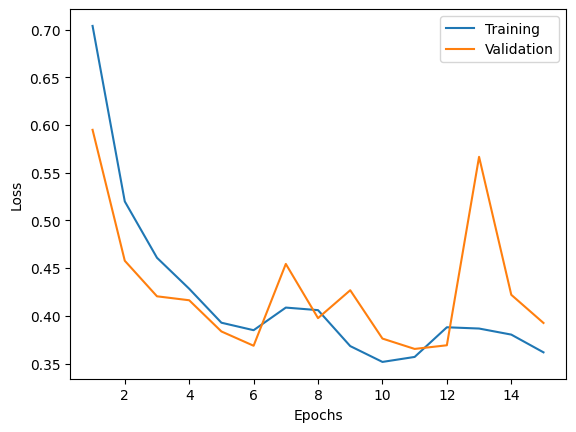

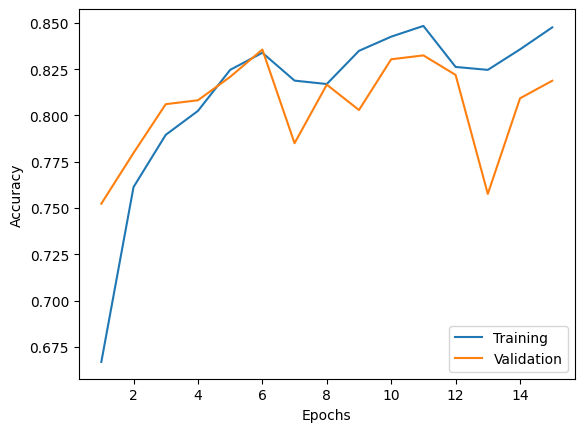

In [ ]:
def plot_accuracy_and_loss(network_history, epochs):
    x_plot = list(range(1,epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history['train']['loss'])
    plt.plot(x_plot, network_history['val']['loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history['train']['accuracy'])
    plt.plot(x_plot, network_history['val']['accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

plot_accuracy_and_loss(cb.log_metrics, epochs)

t-SNE visualization (cutpaste fine tuned)

In [ ]:
input = torch.permute(datamodule.test_dataset.images, (0,3,1,2))
embeddings, l1, l2, l3, l4 = task.model.compute_features(input)
y = datamodule.test_dataset.labels
 
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(embeddings)
tx = tsne_results[:, 0]
ty = tsne_results[:, 1]

df = pd.DataFrame()
df["labels"] = y
df["comp-1"] = tx
df["comp-2"] = ty

/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ubuntu/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
print(l1.shape)
print(l2.shape)
print(l3.shape)
print(l4.shape)
print(embeddings.shape)

torch.Size([527, 64, 64, 64])
torch.Size([527, 128, 32, 32])
torch.Size([527, 256, 16, 16])
torch.Size([527, 512, 8, 8])
torch.Size([527, 512])


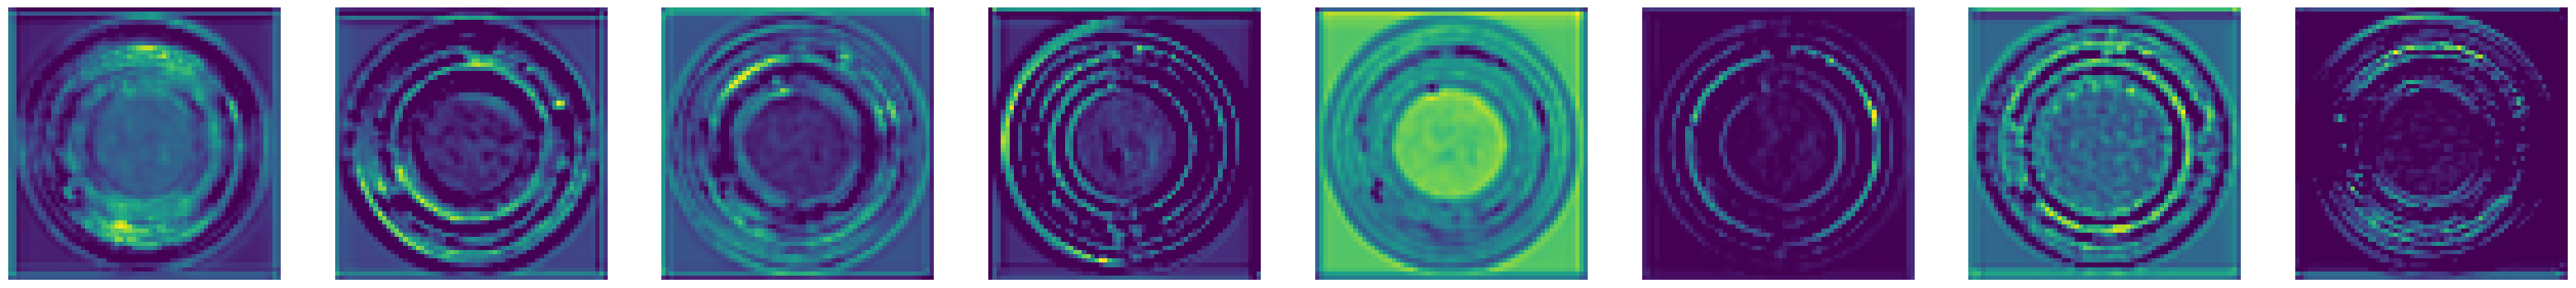

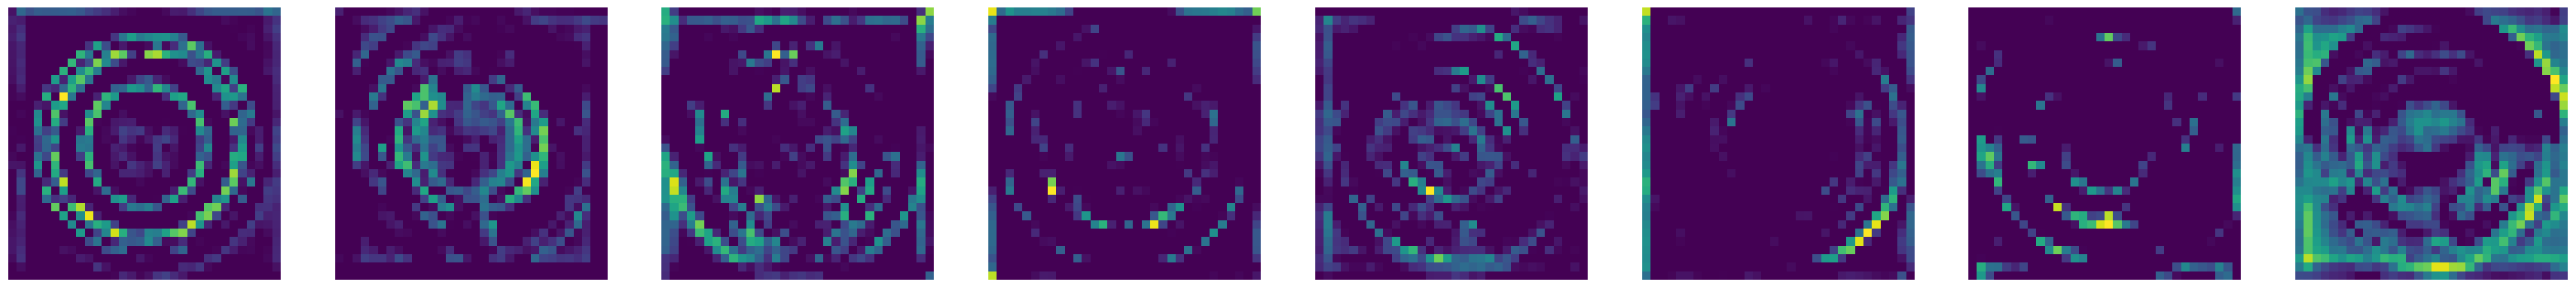

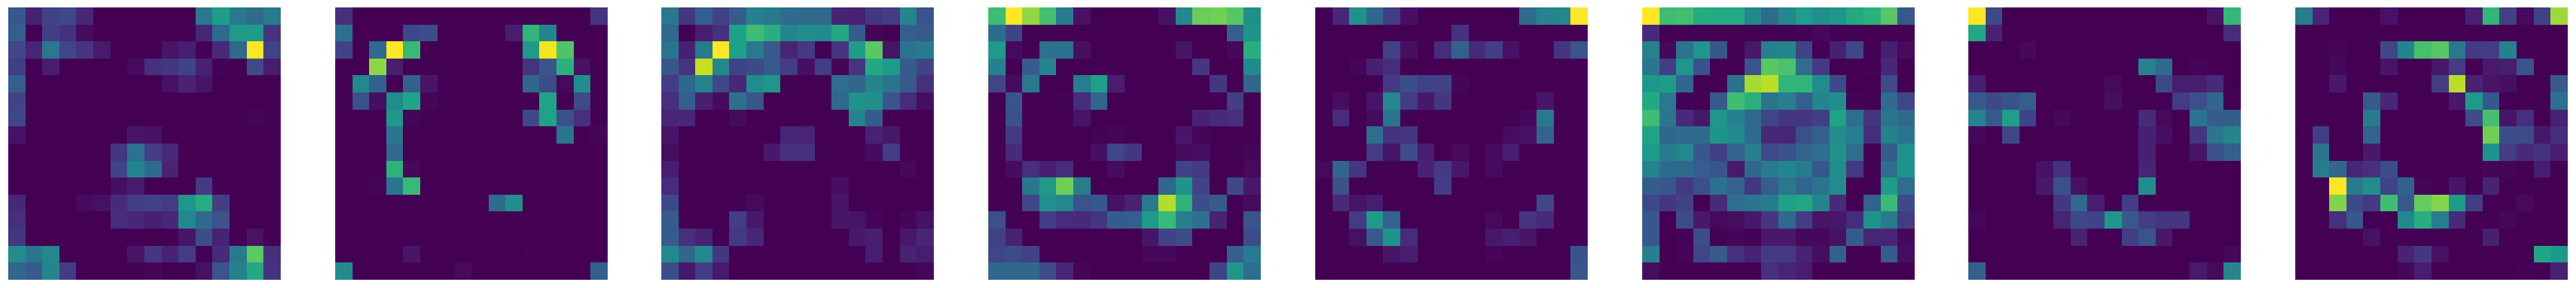

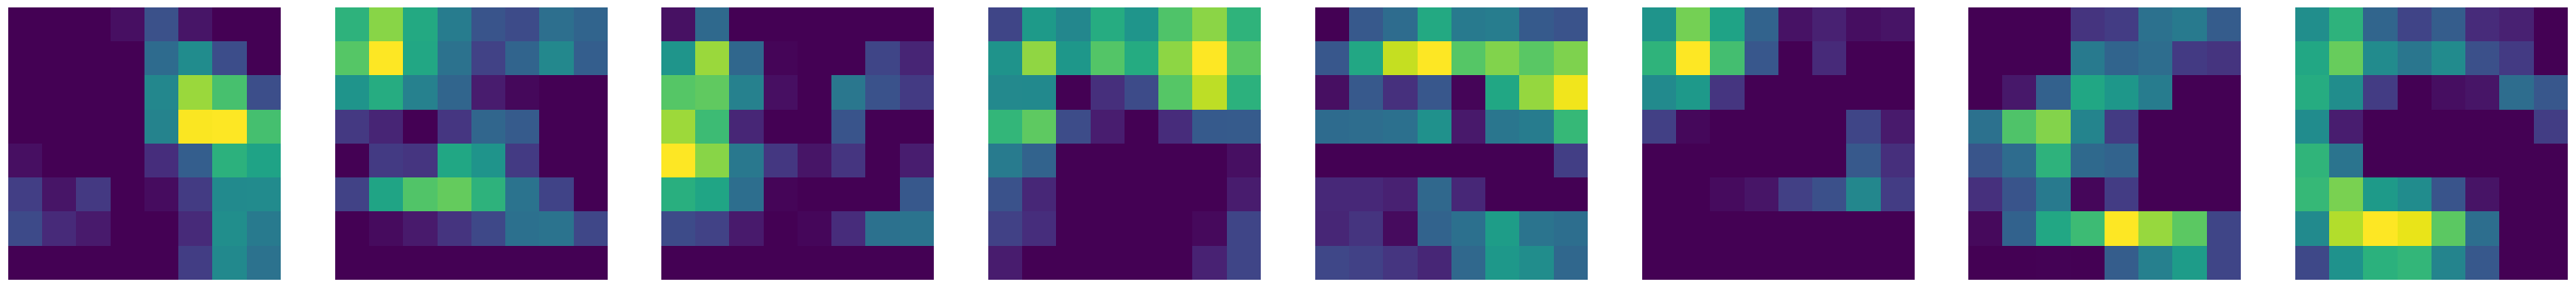

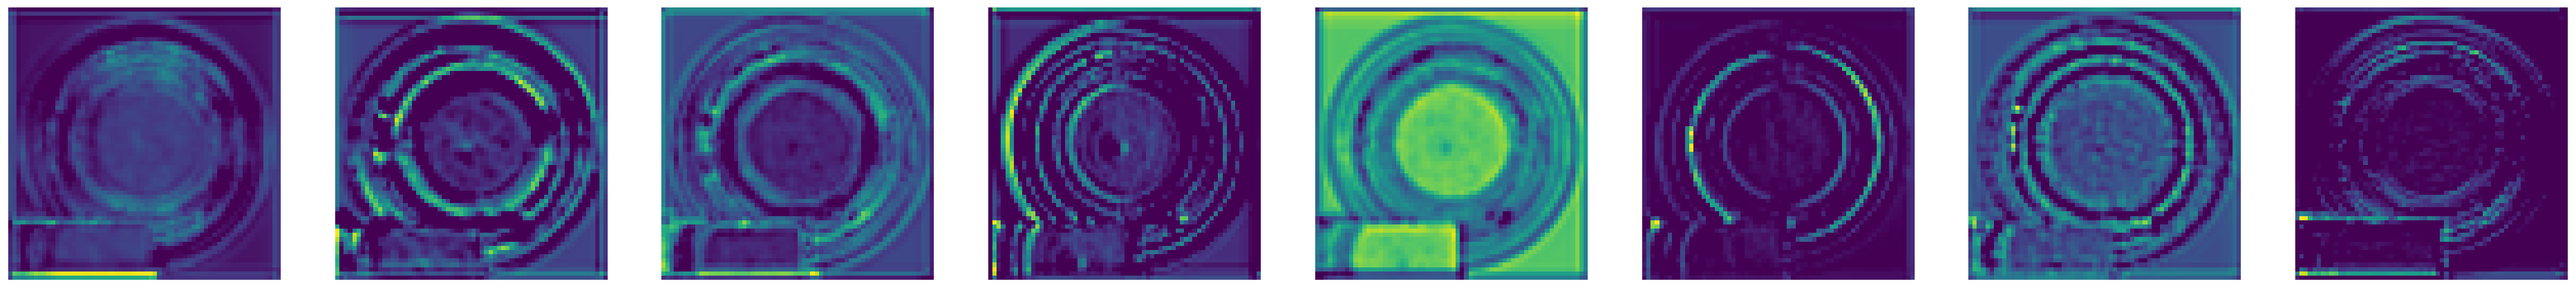

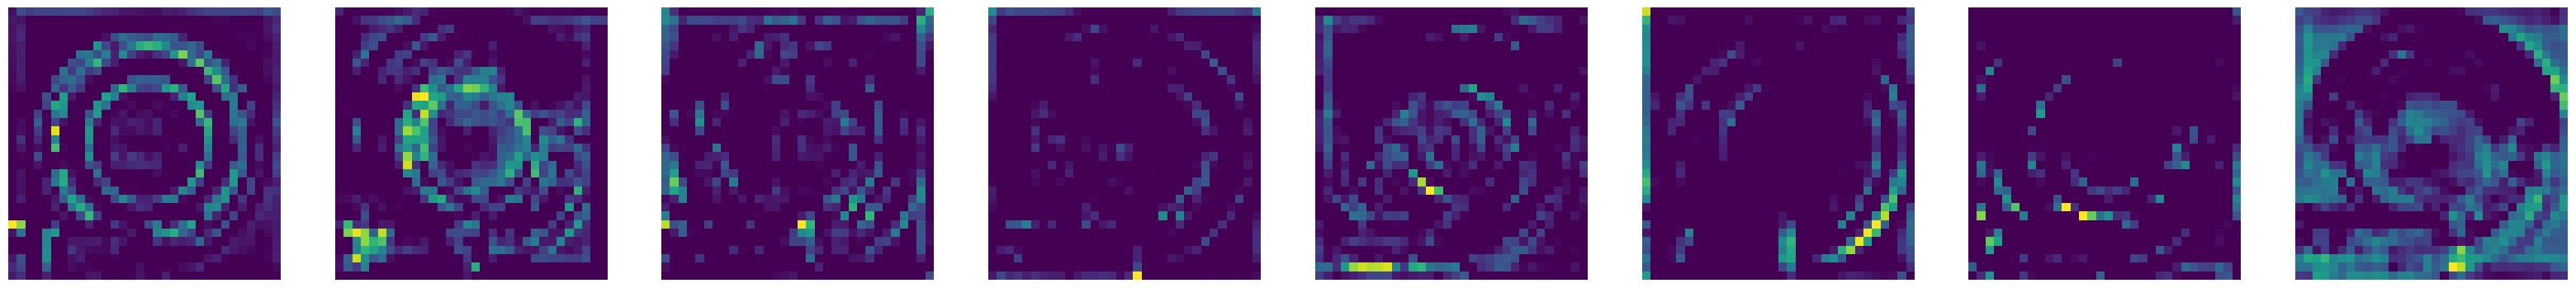

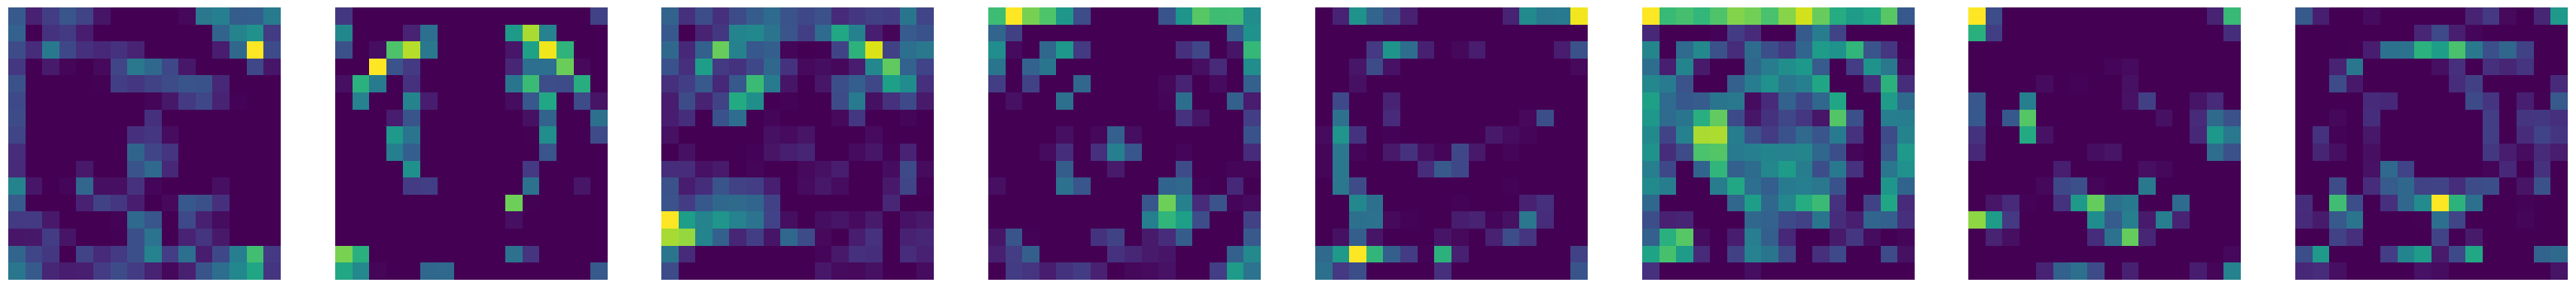

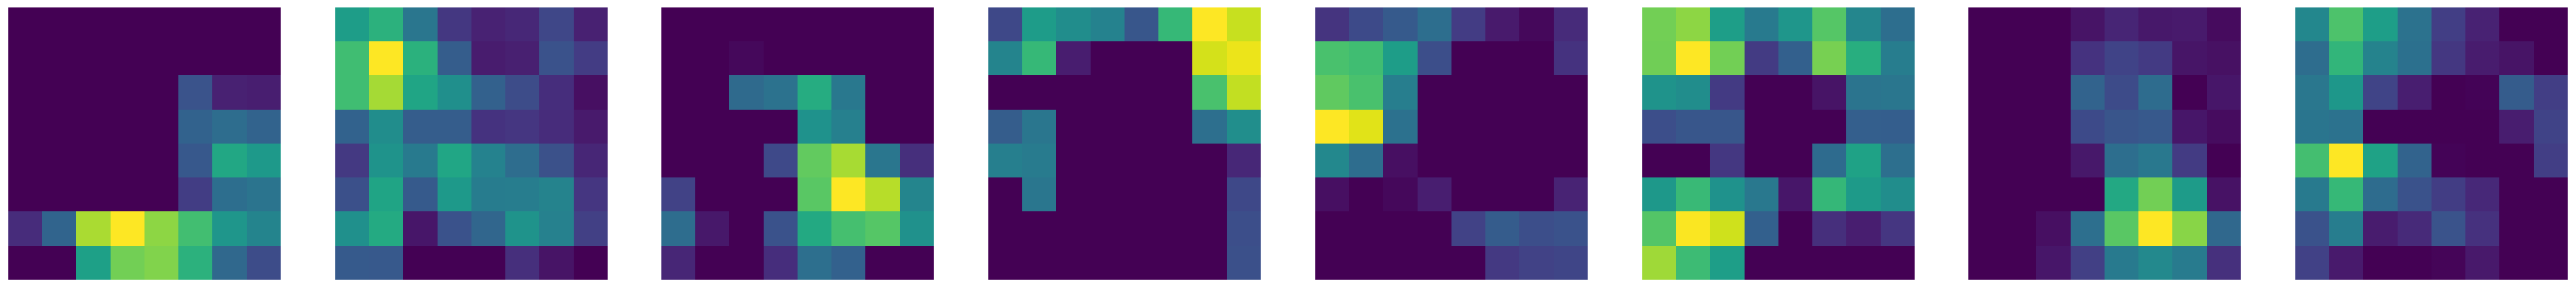

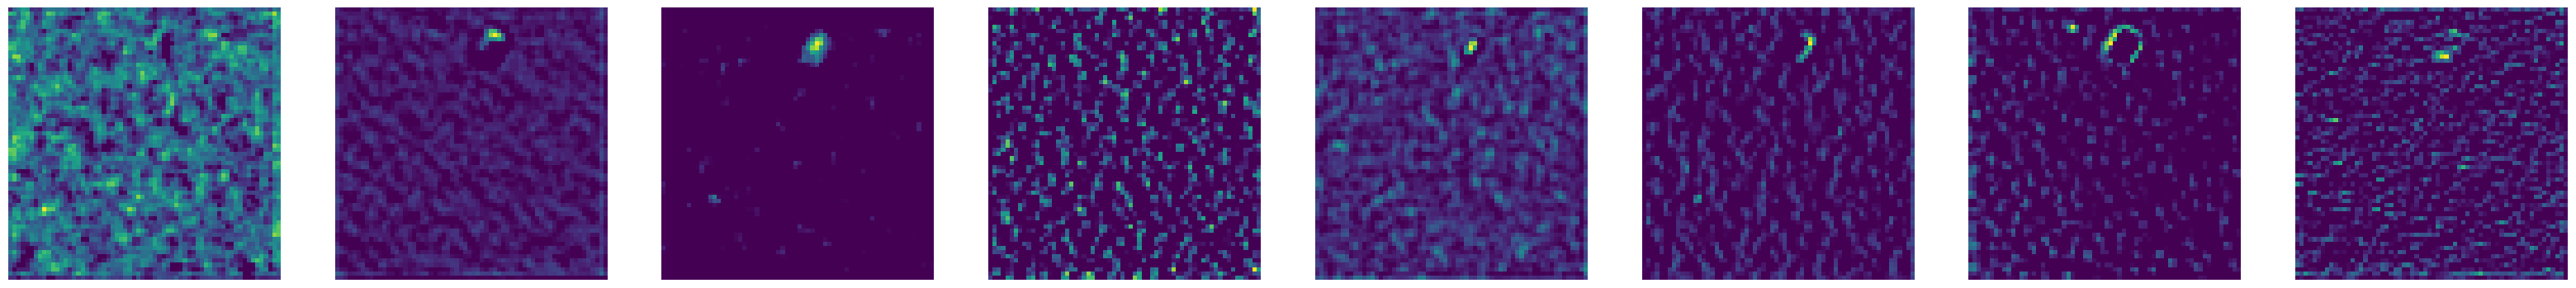

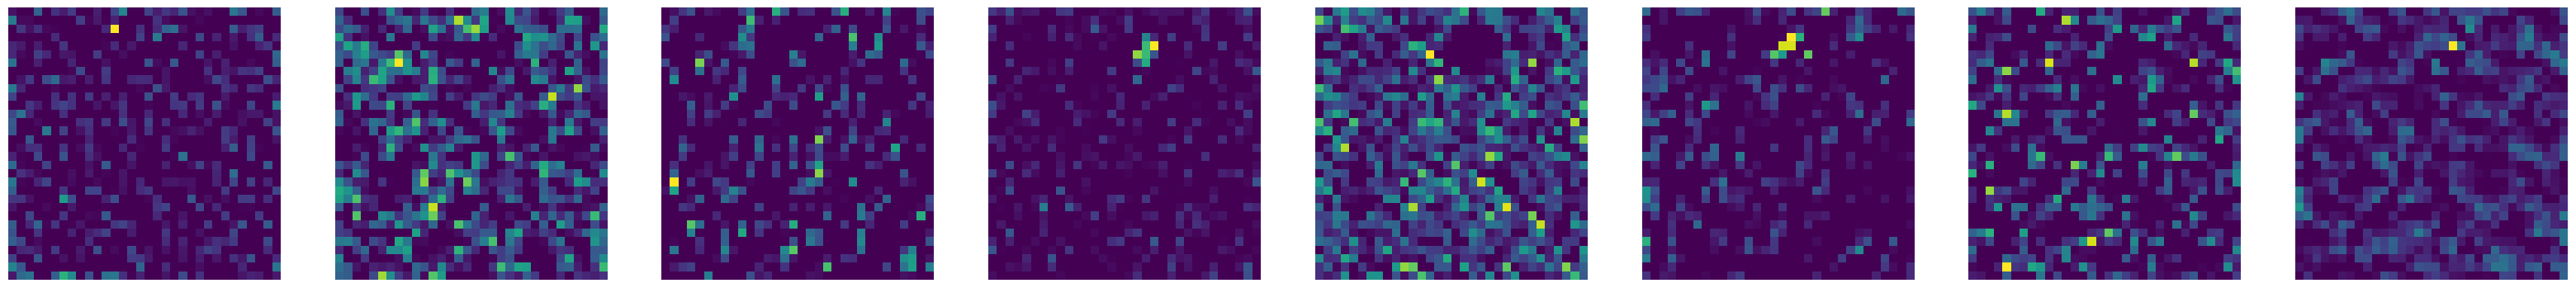

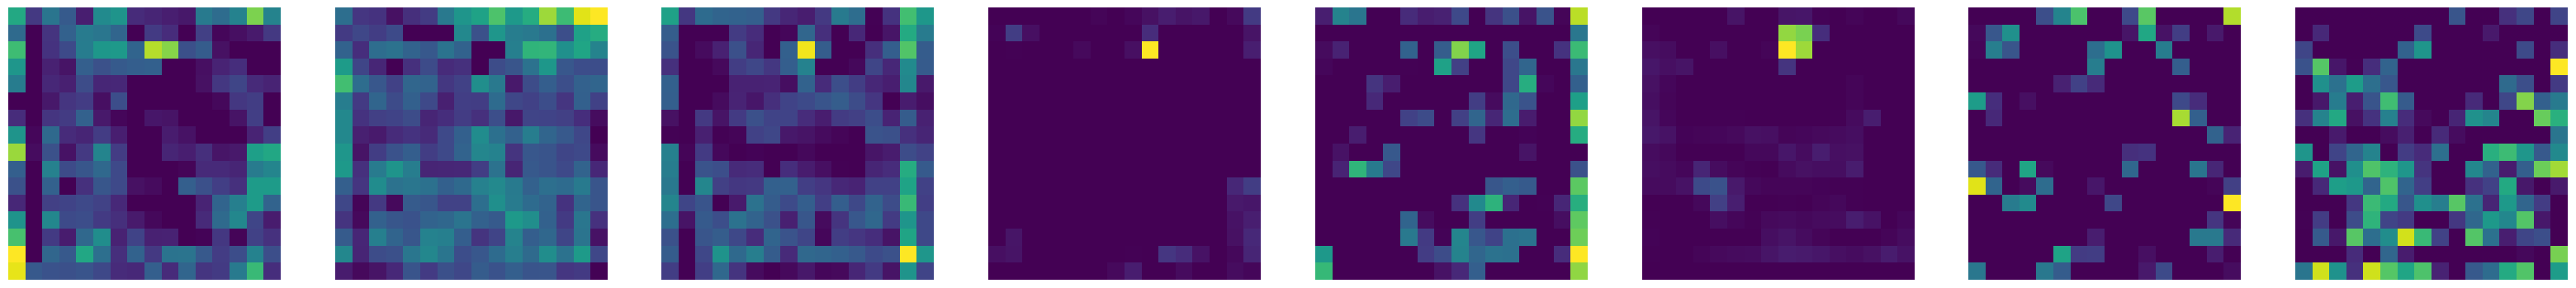

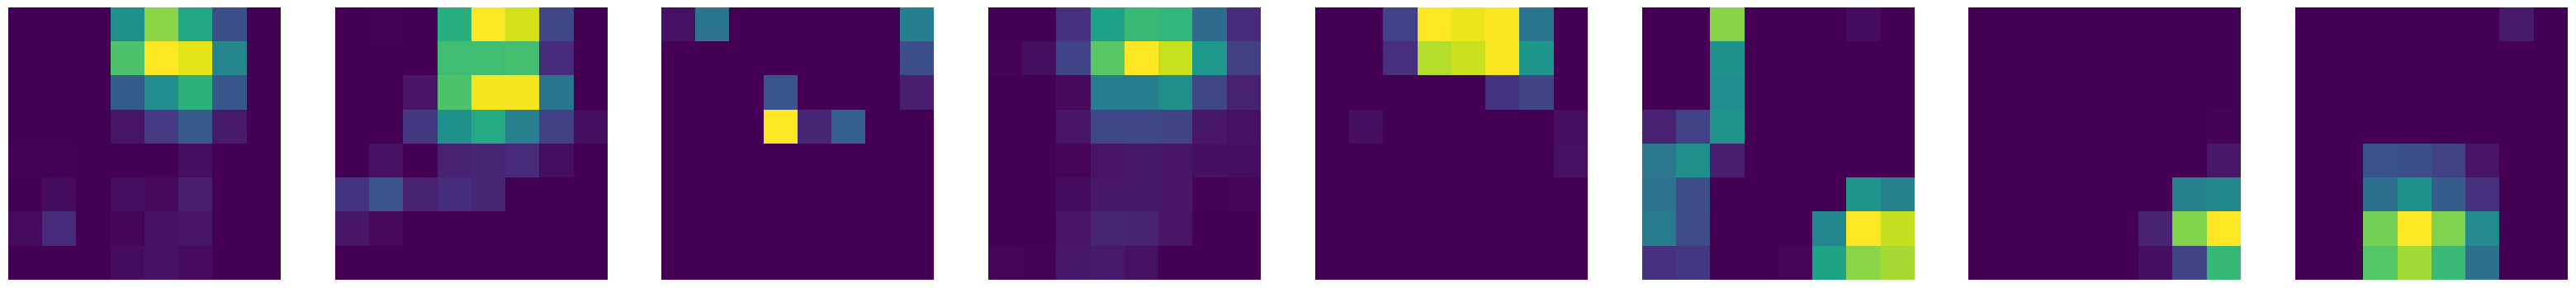

In [ ]:
#image 1
#l1
act = l1[0].squeeze()
limit = 10
num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l2   
act = l2[0].squeeze()
limit = 10
num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l3
act = l3[0].squeeze()
limit = 10

num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 3 (16, 16)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l4
act = l4[0].squeeze()
limit = 10

num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 4 (8, 8)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])

    
#image 2
#l1
act = l1[3].squeeze()
limit = 10
num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 1 (64, 64)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l2   
act = l2[3].squeeze()
limit = 10
num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 2 (32, 32)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l3
act = l3[3].squeeze()
limit = 10

num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 3 (16, 16)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l4
act = l4[3].squeeze()
limit = 10

num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 4 (8, 8)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])

#image 3
#l1
act = l1[4].squeeze()
limit = 10
num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 1 (64, 64)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l2   
act = l2[4].squeeze()
limit = 10
num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 2 (32, 32)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l3
act = l3[4].squeeze()
limit = 10

num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 3 (16, 16)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])
#l4
act = l4[4].squeeze()
limit = 10

num_plot = 8
fig, axarr = plt.subplots(1, min(act.size(0), num_plot), figsize=(40,40))
#fig.suptitle('layer 4 (8, 8)')
for idx in range(min(act.size(0), num_plot)):
    axarr[idx].axis('off')
    axarr[idx].imshow(act[idx])

[Text(0.5, 1.0, 'Generated dataset projection')]

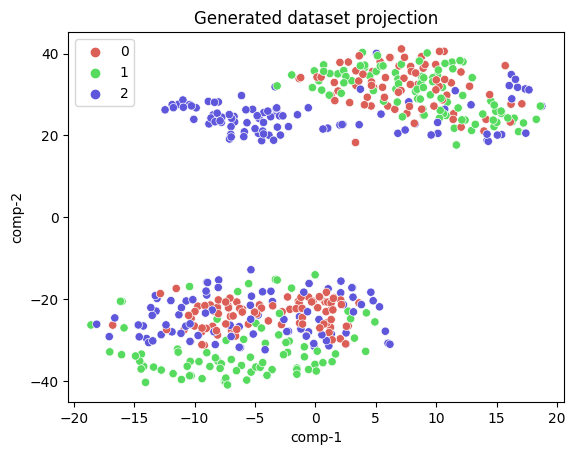

In [ ]:
sns.scatterplot(data=df, x='comp-1',y='comp-2',hue=df.labels.to_list(),
                palette=sns.color_palette("hls", 3),
                ).set(title="Generated dataset projection") 